In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ascanipek/eyepacs-aptos-messidor-diabetic-retinopathy")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\chittes\.cache\kagglehub\datasets\ascanipek\eyepacs-aptos-messidor-diabetic-retinopathy\versions\4


In [5]:
import torch
import torchvision
print(torch.__version__)

2.5.1+cu118


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [14]:
data_dir = os.path.join(path, "eyepacs-aptos-messidor-diabetic-retinopathy")
num_epochs = 60
batch_size = 64
learning_rate = 1e-5
print("Path to dataset files:", path)

Path to dataset files: C:\Users\chittes\.cache\kagglehub\datasets\ascanipek\eyepacs-aptos-messidor-diabetic-retinopathy\versions\4


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Dataset root
data_dir = r"C:\Users\chittes\Downloads\DR_Dataset_extracted\augmented_resized_V2"

# Transforms
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# Datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


# Classes
print("Classes:", train_dataset.classes)

Classes: ['Class 1', 'Class 2']


In [17]:
import torch
import torch.nn as nn

class DRNet(nn.Module):
    def __init__(self):
        super(DRNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.MaxPool2d(2, 2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256 * 7 * 7, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DRNet().to(device)

# Use BCELoss (NOT BCEWithLogitsLoss)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [19]:
from tqdm import tqdm
import torch

def train_model(model, criterion, optimizer, scheduler, num_epochs, device, train_loader, val_loader):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # Shape: (B, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=running_loss/total, acc=correct/total)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = (outputs >= 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                val_bar.set_postfix(val_loss=val_loss/val_total, val_acc=val_correct/val_total)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        if scheduler:
            scheduler.step()

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        print(f"[{epoch+1:02}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [20]:
train_loss, train_acc, val_loss, val_acc = train_model(
    model, criterion, optimizer, scheduler, num_epochs, device, train_loader, val_loader
)

[01/60] Train Loss: 0.4940, Acc: 0.7499 | Val Loss: 0.4290, Acc: 0.7984


[02/60] Train Loss: 0.4301, Acc: 0.7947 | Val Loss: 0.3969, Acc: 0.8184


[03/60] Train Loss: 0.4034, Acc: 0.8106 | Val Loss: 0.3846, Acc: 0.8224


[04/60] Train Loss: 0.3821, Acc: 0.8241 | Val Loss: 0.3697, Acc: 0.8331


[05/60] Train Loss: 0.3730, Acc: 0.8283 | Val Loss: 0.3646, Acc: 0.8354


[06/60] Train Loss: 0.3654, Acc: 0.8330 | Val Loss: 0.3619, Acc: 0.8364


[07/60] Train Loss: 0.3553, Acc: 0.8395 | Val Loss: 0.3541, Acc: 0.8411


[08/60] Train Loss: 0.3528, Acc: 0.8417 | Val Loss: 0.3516, Acc: 0.8430


[09/60] Train Loss: 0.3483, Acc: 0.8431 | Val Loss: 0.3476, Acc: 0.8449


[10/60] Train Loss: 0.3428, Acc: 0.8459 | Val Loss: 0.3479, Acc: 0.8454


[11/60] Train Loss: 0.3411, Acc: 0.8477 | Val Loss: 0.3468, Acc: 0.8457


[12/60] Train Loss: 0.3397, Acc: 0.8475 | Val Loss: 0.3444, Acc: 0.8466


[13/60] Train Loss: 0.3371, Acc: 0.8486 | Val Loss: 0.3437, Acc: 0.8475


[14/60] Train Loss: 0.3363, Acc: 0.8495 | Val Loss: 0.3442, Acc: 0.8475


[15/60] Train Loss: 0.3358, Acc: 0.8510 | Val Loss: 0.3430, Acc: 0.8482


[16/60] Train Loss: 0.3340, Acc: 0.8515 | Val Loss: 0.3411, Acc: 0.8491


[17/60] Train Loss: 0.3339, Acc: 0.8511 | Val Loss: 0.3415, Acc: 0.8487


[18/60] Train Loss: 0.3336, Acc: 0.8509 | Val Loss: 0.3409, Acc: 0.8492


[19/60] Train Loss: 0.3330, Acc: 0.8515 | Val Loss: 0.3415, Acc: 0.8486


[20/60] Train Loss: 0.3325, Acc: 0.8517 | Val Loss: 0.3419, Acc: 0.8489


[21/60] Train Loss: 0.3324, Acc: 0.8521 | Val Loss: 0.3407, Acc: 0.8488


[22/60] Train Loss: 0.3322, Acc: 0.8520 | Val Loss: 0.3407, Acc: 0.8487


[23/60] Train Loss: 0.3327, Acc: 0.8514 | Val Loss: 0.3405, Acc: 0.8493


[24/60] Train Loss: 0.3311, Acc: 0.8532 | Val Loss: 0.3400, Acc: 0.8493


[25/60] Train Loss: 0.3305, Acc: 0.8535 | Val Loss: 0.3405, Acc: 0.8497


[26/60] Train Loss: 0.3317, Acc: 0.8528 | Val Loss: 0.3401, Acc: 0.8498


[27/60] Train Loss: 0.3303, Acc: 0.8537 | Val Loss: 0.3394, Acc: 0.8494


[28/60] Train Loss: 0.3313, Acc: 0.8525 | Val Loss: 0.3398, Acc: 0.8499


[29/60] Train Loss: 0.3310, Acc: 0.8534 | Val Loss: 0.3399, Acc: 0.8496


[30/60] Train Loss: 0.3303, Acc: 0.8532 | Val Loss: 0.3393, Acc: 0.8501


[31/60] Train Loss: 0.3306, Acc: 0.8531 | Val Loss: 0.3399, Acc: 0.8491


[32/60] Train Loss: 0.3314, Acc: 0.8523 | Val Loss: 0.3399, Acc: 0.8497


[33/60] Train Loss: 0.3311, Acc: 0.8523 | Val Loss: 0.3409, Acc: 0.8493


[34/60] Train Loss: 0.3305, Acc: 0.8532 | Val Loss: 0.3394, Acc: 0.8501


[35/60] Train Loss: 0.3311, Acc: 0.8524 | Val Loss: 0.3399, Acc: 0.8498


[36/60] Train Loss: 0.3316, Acc: 0.8530 | Val Loss: 0.3398, Acc: 0.8501


[37/60] Train Loss: 0.3310, Acc: 0.8531 | Val Loss: 0.3399, Acc: 0.8504


[38/60] Train Loss: 0.3313, Acc: 0.8530 | Val Loss: 0.3399, Acc: 0.8499


[39/60] Train Loss: 0.3307, Acc: 0.8532 | Val Loss: 0.3399, Acc: 0.8499


[40/60] Train Loss: 0.3311, Acc: 0.8529 | Val Loss: 0.3396, Acc: 0.8492


[41/60] Train Loss: 0.3307, Acc: 0.8523 | Val Loss: 0.3404, Acc: 0.8494


[42/60] Train Loss: 0.3310, Acc: 0.8530 | Val Loss: 0.3393, Acc: 0.8492


[43/60] Train Loss: 0.3309, Acc: 0.8532 | Val Loss: 0.3396, Acc: 0.8497


[44/60] Train Loss: 0.3304, Acc: 0.8531 | Val Loss: 0.3394, Acc: 0.8501


[45/60] Train Loss: 0.3303, Acc: 0.8531 | Val Loss: 0.3398, Acc: 0.8506


[46/60] Train Loss: 0.3302, Acc: 0.8536 | Val Loss: 0.3402, Acc: 0.8498


[47/60] Train Loss: 0.3318, Acc: 0.8520 | Val Loss: 0.3398, Acc: 0.8504


[48/60] Train Loss: 0.3307, Acc: 0.8524 | Val Loss: 0.3393, Acc: 0.8501


[49/60] Train Loss: 0.3314, Acc: 0.8527 | Val Loss: 0.3400, Acc: 0.8498


[50/60] Train Loss: 0.3311, Acc: 0.8524 | Val Loss: 0.3392, Acc: 0.8497


[51/60] Train Loss: 0.3302, Acc: 0.8529 | Val Loss: 0.3395, Acc: 0.8507


[52/60] Train Loss: 0.3319, Acc: 0.8526 | Val Loss: 0.3397, Acc: 0.8501


[53/60] Train Loss: 0.3306, Acc: 0.8522 | Val Loss: 0.3396, Acc: 0.8497


[54/60] Train Loss: 0.3307, Acc: 0.8530 | Val Loss: 0.3395, Acc: 0.8502


[55/60] Train Loss: 0.3313, Acc: 0.8519 | Val Loss: 0.3399, Acc: 0.8499


[56/60] Train Loss: 0.3300, Acc: 0.8536 | Val Loss: 0.3401, Acc: 0.8499


[57/60] Train Loss: 0.3310, Acc: 0.8530 | Val Loss: 0.3394, Acc: 0.8497


[58/60] Train Loss: 0.3314, Acc: 0.8527 | Val Loss: 0.3393, Acc: 0.8496


[59/60] Train Loss: 0.3296, Acc: 0.8544 | Val Loss: 0.3391, Acc: 0.8502


[60/60] Train Loss: 0.3314, Acc: 0.8530 | Val Loss: 0.3397, Acc: 0.8503


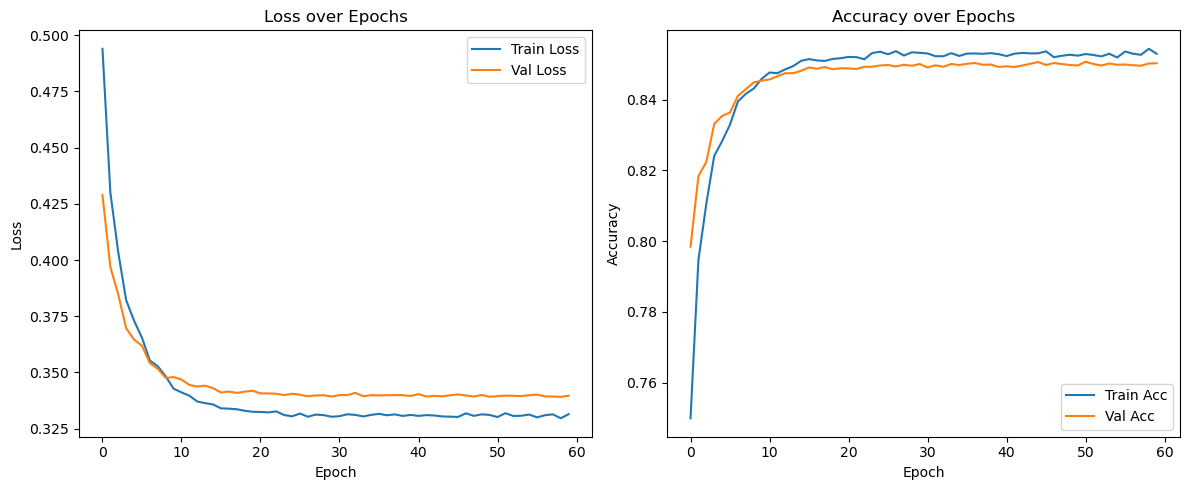

In [21]:
epochs = range(num_epochs)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct, total = 0, 0
    all_preds, all_labels = [], []


    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device) # Unsqueeze labels to match model output shape
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0) # Multiply by batch size for correct total loss

            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    avg_loss = total_loss / total # Divide by total number of samples for average loss
    acc = correct / total

    print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")
    print(f"📉 Test Loss: {avg_loss:.4f}")

    return all_labels, all_preds

# Example call:
test_labels, test_preds = evaluate_model(model, test_loader, criterion)


✅ Test Accuracy: 85.48%
📉 Test Loss: 0.3323
